In [16]:
import numpy as np
from sklearn import preprocessing,cross_validation,neighbors
import pandas as pd
from sklearn import cluster, svm
from __future__ import division
from collections import Counter
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn import metrics
from sklearn.model_selection import train_test_split
import matplotlib.cm as cm
import operator
import matplotlib.pyplot as plt

In [17]:
df=pd.read_csv('e-nose-dataset.csv',nrows=879)
df.drop(['minute'],axis=1,inplace=True)
df.replace(to_replace='good',value='acceptable',inplace=True)
#replacing word categories to numeric categories
df.replace(to_replace=['spoiled','acceptable','excellent'], value=[3,2,1],inplace=True)

X=np.array(df.drop(['class'],1))
y=np.array(df['class'])

#splitting into to test and train
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=0)

#Standardizing the data
scaler = StandardScaler()
scaler.fit(X_train)
X_train=scaler.transform(X_train)
X_test=scaler.transform(X_test)
X = scaler.transform(X)

#decomposition using pca
pca = PCA(n_components=2)
pca.fit(X_train)


X_train = pca.transform(X_train)
X_test = pca.transform(X_test)
X = pca.transform(X)


In [18]:
#training svm on small data, used the test data for training
svm_clf = svm.SVC()
svm_clf.fit(X_test,y_test)
svm_clf.score(X_train,y_train)

0.97581792318634419

In [19]:
#creating data frame for the data obtained after dimenssionality reducition
principalDf = pd.DataFrame(data = X_train
             , columns = ['principal component 1', 'principal component 2'])
target = pd.DataFrame(data=y_train , columns = ['class'])
principalDf.head()
finalDf = pd.concat([principalDf, target[['class']]], axis = 1)
finalDf.head()

,principal component 1,principal component 2,class
0,-4.651110,2.422789,1
1,5.623056,3.034022,3
2,-0.837238,-2.026126,2
3,0.481205,-1.601051,2
4,0.620752,-1.520336,2


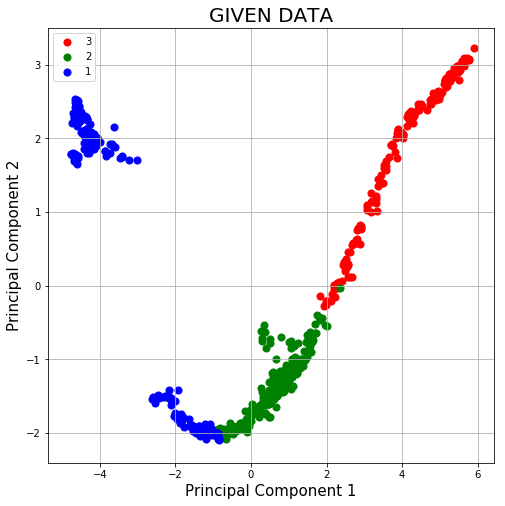

In [21]:
#plotting given data and labels with different colors for different categories
fig = plt.figure(figsize = (8,8))
ax = fig.add_subplot(1,1,1) 
ax.set_xlabel('Principal Component 1', fontsize = 15)
ax.set_ylabel('Principal Component 2', fontsize = 15)
ax.set_title('GIVEN DATA', fontsize = 20)
targets = [3, 2, 1]
colors = ['r', 'g', 'b']
for target, color in zip(targets,colors):
    indicesToKeep = finalDf['class'] == target
    ax.scatter(finalDf.loc[indicesToKeep, 'principal component 1']
               , finalDf.loc[indicesToKeep, 'principal component 2']
               , c = color
               , s = 50)
ax.legend(targets)
ax.grid()

# plotting the outputs of various clustering algorithms

### kmeans

In [22]:
#giving train data as input to k means and have not specified the number of clusters
k_mean_cls = cluster.KMeans()
k_mean_cls.fit(X_train)
km_op_arr = k_mean_cls.fit_predict(X_train)
#creating data frame with 2d pca data and their output prediction in km_op column
target = pd.DataFrame(data=km_op_arr , columns = ['km_op'])
finalDf = pd.concat([principalDf, target[['km_op']]], axis = 1)
print(finalDf.head())
cls_cen=k_mean_cls.cluster_centers_
k_mean_cls.cluster_centers_

   principal component 1  principal component 2  km_op
0              -4.651110               2.422789      1
1               5.623056               3.034022      5
2              -0.837238              -2.026126      6
3               0.481205              -1.601051      0
4               0.620752              -1.520336      0


array([[ 0.52629079, -1.4312559 ],
       [-4.3960036 ,  2.09286698],
       [ 3.90617253,  1.95860529],
       [ 2.54429394,  0.33545884],
       [-1.70354021, -1.81326156],
       [ 5.29040308,  2.82480903],
       [-0.52043282, -1.9341    ],
       [ 1.3090523 , -0.95125821]])

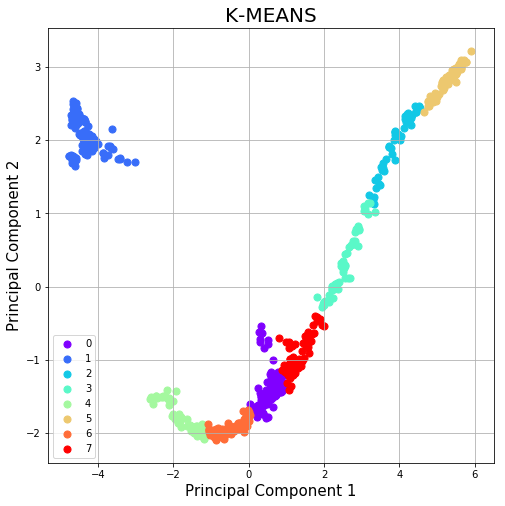

In [23]:
#plotting the output categories classified by k means
fig = plt.figure(figsize = (8,8))
ax = fig.add_subplot(1,1,1) 
ax.set_xlabel('Principal Component 1', fontsize = 15)
ax.set_ylabel('Principal Component 2', fontsize = 15)
ax.set_title('K-MEANS', fontsize = 20)
targets = list(range(len(arr)))
#targets = [0, 1, 2, 3, 4, 5, 6, 7]
colors = cm.rainbow(np.linspace(0, 1, len(cls_cen)))
#colors = ['r', 'g', 'b' , 'y' , 'o' , 'v' , 'p' , 'm']
for target, color in zip(targets,colors):
    indicesToKeep = finalDf['km_op'] == target
    ax.scatter(finalDf.loc[indicesToKeep, 'principal component 1']
               , finalDf.loc[indicesToKeep, 'principal component 2']
               , c = color
               , s = 50)
ax.legend(targets)
ax.grid()

In [24]:
label_ind_dict = finalDf.groupby('km_op').groups #indexes list for each class given as dictionary 
label_li=finalDf.groupby('km_op').groups.keys()  #getting keys of above mentioned dictionary
actual_lab_dict={}

for i in range(len(label_li)):
    index_lis=label_ind_dict[i]
    freq_dict={}
    #finding maximum actual output labels for a cluster label based on svm output
    for j in range(len(index_lis)):
        inp = np.zeros((1,2))
        inp[0][0] = finalDf.loc[index_lis[j],'principal component 1']
        inp[0][1] = finalDf.loc[index_lis[j],'principal component 2']
        op = svm_clf.predict(inp)
        if op[0] in  freq_dict:
            freq_dict[op[0]] = freq_dict[op[0]] + 1
        else:
            freq_dict[op[0]] = 1
        #highest frequency
    actual_lab_dict[label_li[i]] = max(freq_dict.iteritems(), key=operator.itemgetter(1))[0]
        
        

In [25]:
#predicting the target class label for each cluster 
actual_lab_dict

{0L: 2, 1L: 1, 2L: 3, 3L: 3, 4L: 1, 5L: 3, 6L: 2, 7L: 2}

In [14]:
#replacing the cluster category ie., 0,1,2,3,4,5,6,7.. with 1, 2, 3
solDf = finalDf.replace(actual_lab_dict)
op=np.array(solDf['km_op'])
#comparing our predictions with actual outputs in ytrain
perc=0
for i in range(len(op)):
    if op[i]==y_train[i]:
        perc=perc+1
    


perc=perc/len(op) 
perc       

0.9800853485064012

### spectral clustering

In [12]:
spect_cls = cluster.SpectralClustering(n_clusters=3)
spect_cls.fit(X_train)
op_arr = spect_cls.fit_predict(X_train)
target = pd.DataFrame(data=op_arr , columns = ['op'])
finalDf = pd.concat([principalDf, target[['op']]], axis = 1)
finalDf.head()

,principal component 1,principal component 2,op
0,-0.028421,-1.592013,2
1,-0.642982,-1.969405,2
2,1.777116,-0.563875,2
3,4.956237,2.656457,0
4,-0.546859,-1.928965,2


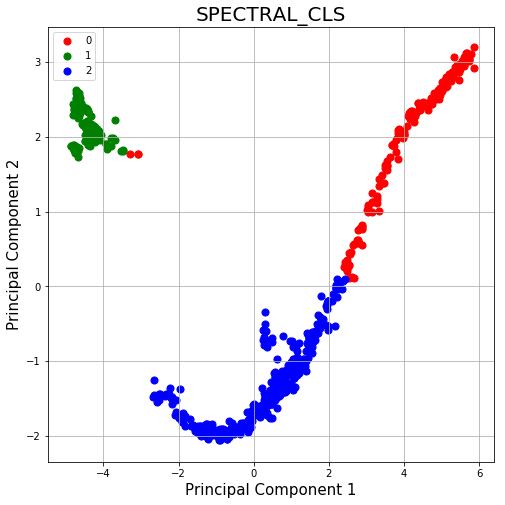

In [13]:
import matplotlib.pyplot as plt
fig = plt.figure(figsize = (8,8))
ax = fig.add_subplot(1,1,1) 
ax.set_xlabel('Principal Component 1', fontsize = 15)
ax.set_ylabel('Principal Component 2', fontsize = 15)
ax.set_title('SPECTRAL_CLS', fontsize = 20)
targets = [0, 1, 2]
colors = ['r', 'g', 'b']
for target, color in zip(targets,colors):
    indicesToKeep = finalDf['op'] == target
    ax.scatter(finalDf.loc[indicesToKeep, 'principal component 1']
               , finalDf.loc[indicesToKeep, 'principal component 2']
               , c = color
               , s = 50)
ax.legend(targets)
ax.grid()

In [14]:
arr

NameError: name 'arr' is not defined

In [ ]:
arr1 = k_mean_cls.fit_predict(X[700:800])
arr1

### train a supervised learning classifier

In [ ]:
svm_clf.predict(k_mean_cls.cluster_centers_)

In [15]:
arr = spect_cls.fit_predict(X[0:879])
arr1 = svm_clf.predict(X[0:879])
change={ 0:2, 1:3 , 2:1}

def change_lab(x):
    y=change[x]
    return y

for i in range(len(arr)):
    arr[i]=change_lab(arr[i])
    
perc=0
for i in range(len(arr)):
    if arr[i]==y[i]:
        perc=perc+1
    


perc=perc/len(arr) 
perc       

0.4482366325369738